# Generate Anchor Output

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
#import seaborn as sns
import numpy as np

In [2]:
path = r'C:\Users\dazhong.li\Desktop\C1087'
os.chdir(path)


# Generate the Property table for Anchors

In [3]:
anchor_list = [i for i in os.listdir() if 'Anchors' in i]
lst=[]
for file in anchor_list:
    temp_df = pd.read_csv(file,sep='\t')
    temp_df.drop(temp_df.columns[[0,1]],axis=1,inplace=True)
    lst.append(temp_df)
material_df = pd.concat(lst,axis=1)
material_df = material_df.transpose()
material_df.drop(material_df.columns[[0,1,2,3]],axis=1,inplace=True)
material_df.sort_index(inplace=True)
material_df.columns=['EA','L-Spacing','Max Ten','Max Comp']
material_df['Material ID'] = material_df.index
material_df.to_excel('anchor properties.xlsx')

# Generate the Table for Anchors results

In [4]:
anchor_list = [i for i in os.listdir() if 'Node-to-node anchor' in i]
lst=[]
for file in anchor_list:
    temp_df = pd.read_csv(file,sep='\t')
    x = [i.strip() for i in temp_df.columns]
    temp_df.columns=x
    temp_df['X [m]'] = temp_df['X [m]'].astype('float')
    temp_df['Y [m]'] = temp_df['Y [m]'].astype('float')
    lst.append(temp_df)
    
def find_hoop_force (anchor_result,y_loc,R=15.597):
    '''
    This function calculate the hoop force given the anchor result. 
    Parameter: 
        anchor_result: a data frame containing the anchor result in a form of 'xa','ya','xb','yb','F','Fmax'
        y_loc: a string indicating the location to be calculated, either 'ya' or 'yb'
        R: radius of the circular structure, the default value is what we've been using for the project at BCF
    Return:
        A data from contaning the hoop force in a form of y|force
                                    
    '''
    hoop_force = pd.DataFrame(dict(y=[],force=[]))
    hoop_force.set_index('y')
    for y in sorted(set(anchor_result[y_loc]),reverse=True):
        point_result = anchor_result[abs(anchor_result[y_loc] -y) <0.1]
        H = 0
        R = 15.597
        N = 0
        for xa, ya, xb, yb, Nmax in zip(point_result.xa,
                                  point_result.ya,
                                  point_result.xb,
                                  point_result.yb,point_result.F):
            H += 0.5*abs(yb-ya)
            theta = np.arctan((yb - ya)/(xb - xa))
            N += Nmax*np.cos(theta)
        hoop_force.loc[y,'force']=N*R/H
        hoop_force.loc[y,'y']=y
    return hoop_force

In [5]:
count =0
for i , df_force in enumerate(lst):
    result = pd.DataFrame()
    for index,row in df_force.iterrows():
        #import pdb
        #pdb.set_trace()
        if index%2 == 1:
            continue 
        if index > df_force.count()[0]-1:
            break
        ID = row[0]
        material = df_force.iloc[index+1,0].strip()
        x =0,
        y =0,
        x1 = row[3]
        x2 = df_force.iloc[index+1,3]
        centroid = 0.5*(row[4]+df_force.iloc[index+1,4])
        try:
            if x1>x2:
                xa = x2
                ya = df_force.iloc[index+1,4]
                xb = x1
                yb = row[4]
                result[ID] = [material[1:-1],xa,ya,xb,yb, centroid,row[5],row[6],row[7]]
            else:
                xa = x1
                ya = row[4]
                xb = x2
                yb = df_force.iloc[index+1,4]
                result[ID] = [material[1:-1],xa,ya,xb,yb,centroid,row[5],row[6],row[7]]
        except:
            print(ID)
            print('x1={}'.format(x1))
            print('x2={}'.format(x2))
            
    result=result.transpose()
    result.columns = ['Material ID','xa','ya','xb','yb','centroid','N','Nmin','Nmax']
    result.sort_values(by=['ya','centroid'],ascending=[False,False],inplace=True)
    anchor_result = result.merge(material_df,on='Material ID',right_index=True)
    anchor_result['EA'] = anchor_result['EA'].astype('float')
    seaward_hoop_force = find_hoop_force(anchor_result[abs(anchor_result.xb-26.7)<0.1])
    #anchor_result['Angle'] = anchor_result.apply(lambda row: np.rad2deg((row['yb']-row['ya'])/(row['xb']-row['xa'])),axis=1)
    #anchor_result['Height'] = 0.5*np.abs(anchor_result.yb-anchor_result.ya)
    radius_of_cell = 15.597
    #anchor_result['Hoop Force'] = anchor_result.Nmax/anchor_result.Height*radius_of_cell*np.cos(np.deg2rad(anchor_result.Angle))
    file_name = anchor_list[i][anchor_list[i].find('_ Node-to-node anchor_ ')+len('_ Node-to-node anchor_ '):-1]
    file_name = file_name[:file_name.find('[')]
    seaward_hoop_force.to_excel('{}-'.format(count) + file_name+'.xlsx')
    #anchor_result.to_excel('{}-'.format(count) + file_name+'.xlsx')
    #count=count+1


# Let's plot the result

In [6]:
before_FOS_file = '0-Permanent Undrained Case .xlsx'
FOS_file = '0-FOS - Permanent Undrained Case .xlsx'
anchor_prior_FOS = pd.read_excel(before_FOS_file)
anchor_FOS = pd.read_excel(FOS_file)

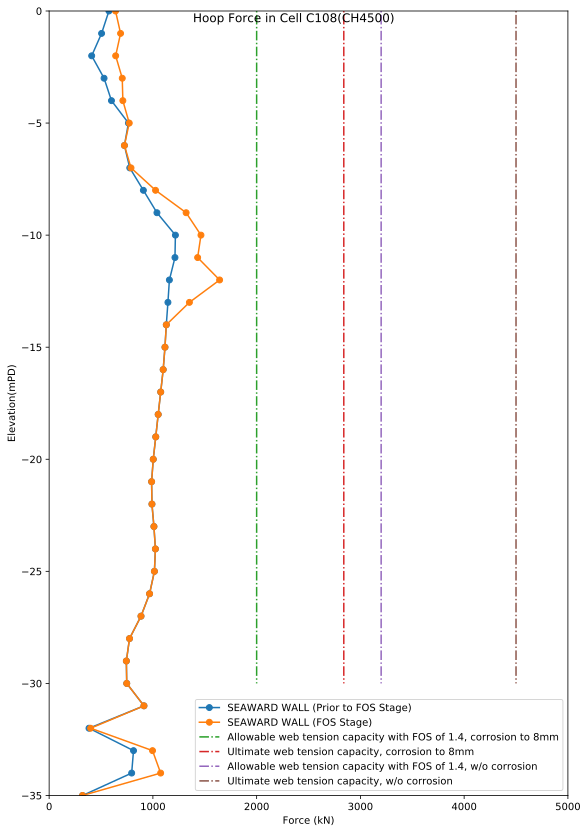

In [8]:
fig = plt.figure(figsize=(8.27,11.69))
title = 'Hoop Force in Cell C108(CH4500)'
ax = fig.add_subplot(111)
#ax.plot(x=[2000,2000],y=[anchor.y.min(),anchor.y.max()])
fig.suptitle (title)
#ax.legend()
ax.set_ylabel('Elevation(mPD)')
ax.set_xlabel('Force (kN)')
ax.set_xlim(0,5000)
ax.set_ylim(-35,-0)
ax.plot(np.array(anchor_prior_FOS['force']),
                 anchor_prior_FOS['y'],
                 marker='o',
                 label='SEAWARD WALL (Prior to FOS Stage)'
                )
ax.plot(np.array(anchor_FOS['force']),
        np.array(anchor_FOS['y']),
        marker='o',
        label='SEAWARD WALL (FOS Stage)'
       )
#add the limit lines
ax.plot([2000,2000],[5,-30],label= 'Allowable web tension capacity with FOS of 1.4, corrosion to 8mm',linestyle='-.')
ax.plot([2840,2840],[5,-30],label= 'Ultimate web tension capacity, corrosion to 8mm',linestyle='-.')
ax.plot([3200,3200],[5,-30],label= 'Allowable web tension capacity with FOS of 1.4, w/o corrosion',linestyle='-.')
ax.plot([4500,4500],[5,-30],label= 'Ultimate web tension capacity, w/o corrosion',linestyle='-.')
ax.legend(loc=4)
fig.tight_layout()
fig.savefig(title + '.pdf')

In [21]:
x = np.array([1,2,3])
y = np.array([4,2,1])
np.maximum(x,y)

array([4, 2, 3])

In [ ]:
anchor_prior_FOS

In [ ]:
anchor_FOS['Hoop Force'] = np.maximum(pd.read_excel(FOS_file).iloc[1::2,:]['Hoop Force'],
                                            pd.read_excel(FOS_file).iloc[0::2,:]['Hoop Force'])

In [ ]:
anchor_FOS['Hoop Force']

In [ ]:
sorted?

In [ ]:
ys = sorted(set(anchor_result.ya),reverse=True)

In [ ]:
point_result = anchor_result[abs(anchor_result.ya -1) <0.1]

In [ ]:
point_result

In [ ]:
assert(len(point_result))<3

In [ ]:
def find_hoop_force (anchor_result):
    hoop_force = pd.DataFrame(dict(y=[],force=[]))
    hoop_force.set_index('y')
    for y in sorted(set(anchor_result.ya),reverse=True):
        point_result = anchor_result[abs(anchor_result.ya -y) <0.1]
        H = 0
        R = 15.597
        N = 0
        for xa, ya, xb, yb, Nmax in zip(point_result.xa,
                                  point_result.ya,
                                  point_result.xb,
                                  point_result.yb,point_result.Nmax):
            H += 0.5*abs(yb-ya)
            theta = np.arctan((yb - ya)/(xb - xa))
            N += Nmax*np.cos(theta)
        hoop_force.loc[y,'force']=N*R/H
    return hoop_force

In [ ]:
abs(anchor_result.xa-26.7)<0.1

In [ ]:
anchor_prior_FOS